### Import libraries

In [1]:
import sys
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [44]:
from util import set_gpu_limit,plot_metrics,cate_embed_process,embed_model_setup,partial,param_search
from carPrice import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")

### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants for base model

In [7]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [8]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### train, dev, and test data for NN

* model embed model input 
* transmission embed model input
* fuelType embed model input 
* numeric input data 

In [9]:
carPrice_embed = carPrice(data,None,NN=True,batch_size=BATCH_SIZE,embed=True)

In [10]:
X_train,X_test,y_train,y_test = carPrice_embed.data_split(1988,0.1)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,random_state=1988,test_size=0.1)

In [11]:
base_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr)

In [27]:
base_embed_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 4)]          0                                            
____________________________________________________________________________________________

In [28]:
carPrice_embed.base = base_embed_model
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [33]:
carPrice_embed.regression_metrics(train_input,y_train,test_input,y_test,retrain=False,train_dataset=(train_input,y_train),
                                 dev_dataset=(dev_input,y_dev),epochs=MAX_EPOCH,V=1,callbacks=[earlystop])

,r2_score,rmse,price_diff_abs_max
train,0.941325,2385.292529,742.077289
test,0.932867,2610.681067,288.303445


In [34]:
base_embed_model = carPrice_embed.regressor 
history = carPrice_embed.history

In [35]:
base_embed_model.save("cate_embed_base_model.h5")

In [36]:
# base_embed_model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

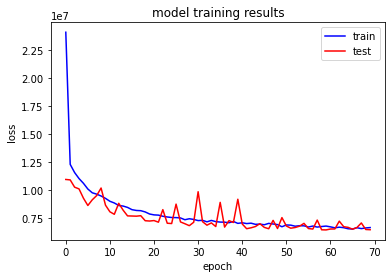

In [37]:
plot_metrics(history,"loss")

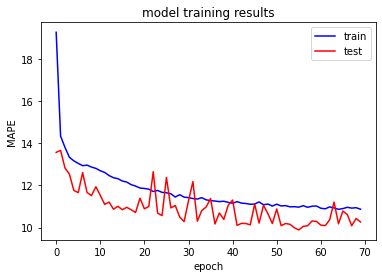

In [38]:
plot_metrics(history,"MAPE")

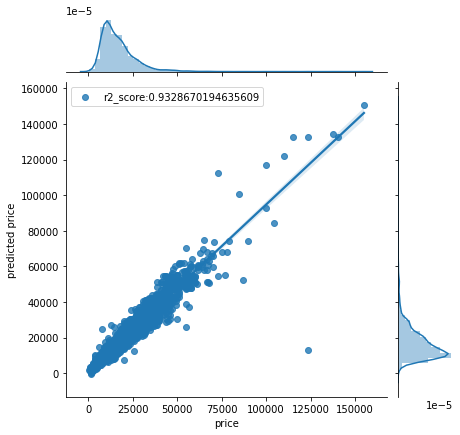

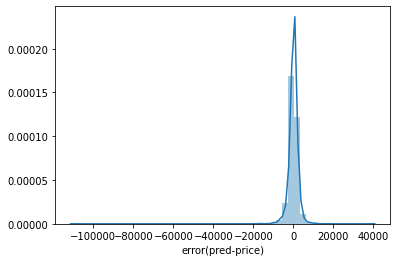

In [39]:
carPrice_embed.plot_pred_price(X_embed=test_input,y_embed=y_test)

In [42]:
price_table = carPrice_embed.price_diff(test_input,y_test)

In [43]:
price_table.head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
72016,Focus,Manual,Petrol,1,5,2,0,288.303445,288.303445
29517,GLE Class,Semi-Auto,Diesel,3,4,2,1,224.210408,224.210408
44645,Corsa,Manual,Petrol,1,3,2,0,198.144953,198.144953
70592,Fiesta,Manual,Diesel,1,4,4,0,182.596156,182.596156
12301,Golf,Manual,Petrol,2,4,2,0,153.268001,153.268001
27927,Octavia,Manual,Petrol,2,4,2,0,148.733632,148.733632
98140,A3,Manual,Petrol,2,3,2,0,142.654572,142.654572
27964,Octavia,Manual,Diesel,1,5,3,0,138.518395,138.518395
54911,Vectra,Automatic,Diesel,1,5,1,0,-131.503597,131.503597
40088,C Class,Manual,Diesel,4,0,3,0,109.374682,109.374682


### Similar to other models, cars that are old with high mileage tend to be over predicted by the model 

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [44]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [45]:
bigger_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,1.5)

In [46]:
bigger_embed_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 4)]          0                                            
____________________________________________________________________________________________

In [47]:
carPrice_embed.base = bigger_embed_model

In [48]:
carPrice_embed.regression_metrics(train_input,y_train,test_input,y_test,retrain=True,train_dataset=(train_input,y_train),
                                 dev_dataset=(dev_input,y_dev),epochs=MAX_EPOCH,V=1,callbacks=[earlystop])

Epoch 1/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 29423208.0000 - MAPE: 21.6712 - MAE: 3214.8767 - val_loss: 12296606.0000 - val_MAPE: 14.1937 - val_MAE: 2226.4041
Epoch 2/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 12751584.0000 - MAPE: 14.6723 - MAE: 2228.9602 - val_loss: 10969114.0000 - val_MAPE: 15.1489 - val_MAE: 2232.7405
Epoch 3/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 11823927.0000 - MAPE: 14.0314 - MAE: 2141.7300 - val_loss: 10495562.0000 - val_MAPE: 13.0639 - val_MAE: 2088.1296
Epoch 4/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 11411301.0000 - MAPE: 13.7200 - MAE: 2098.8972 - val_loss: 10914413.0000 - val_MAPE: 13.0655 - val_MAE: 2111.6448
Epoch 5/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 11099135.0000 - MAPE: 13.5485 - MAE: 2072.6431 - val_loss: 9923338.0000 - val_MAPE: 12.6025 - val_MAE: 1994.9141
Epoch 6/1000
2511/2511 [=================

Epoch 44/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6840366.5000 - MAPE: 11.0846 - MAE: 1713.8802 - val_loss: 6717786.0000 - val_MAPE: 10.1772 - val_MAE: 1643.7310
Epoch 45/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6954075.0000 - MAPE: 11.0692 - MAE: 1717.4734 - val_loss: 7470280.5000 - val_MAPE: 10.9240 - val_MAE: 1732.2150
Epoch 46/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6852915.5000 - MAPE: 11.0620 - MAE: 1709.6874 - val_loss: 6742757.0000 - val_MAPE: 10.8031 - val_MAE: 1680.2545
Epoch 47/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6771238.5000 - MAPE: 11.0231 - MAE: 1704.8392 - val_loss: 7334982.5000 - val_MAPE: 10.1969 - val_MAE: 1684.0195
Epoch 48/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6781643.5000 - MAPE: 11.0158 - MAE: 1705.1924 - val_loss: 6691153.5000 - val_MAPE: 10.3975 - val_MAE: 1644.6171
Epoch 49/1000
2511/2511 [====================

Epoch 87/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6183135.0000 - MAPE: 10.4876 - MAE: 1623.6301 - val_loss: 6413040.5000 - val_MAPE: 9.8448 - val_MAE: 1595.1644
Epoch 88/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6234638.0000 - MAPE: 10.5167 - MAE: 1629.6370 - val_loss: 6371568.5000 - val_MAPE: 9.9415 - val_MAE: 1580.7999
Epoch 89/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6143345.5000 - MAPE: 10.5279 - MAE: 1628.7384 - val_loss: 6545338.5000 - val_MAPE: 9.8794 - val_MAE: 1587.0308
Epoch 90/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6224418.0000 - MAPE: 10.4806 - MAE: 1626.7739 - val_loss: 6473059.5000 - val_MAPE: 11.0941 - val_MAE: 1664.0197
Epoch 91/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 6120983.5000 - MAPE: 10.4727 - MAE: 1622.8086 - val_loss: 6420942.5000 - val_MAPE: 10.0199 - val_MAE: 1597.4512
Epoch 92/1000
2511/2511 [=======================

,r2_score,rmse,price_diff_abs_max
train,0.942668,2357.837485,692.361763
test,0.934686,2575.067481,357.120571


In [49]:
bigger_embed = carPrice_embed.regressor
history = carPrice_embed.history

In [50]:
bigger_embed_model.save("bigger_embed.h5")

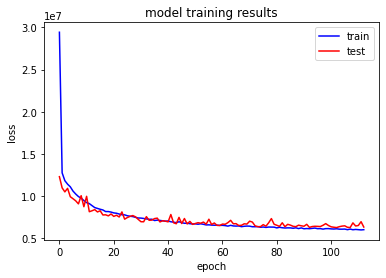

In [51]:
plot_metrics(history,"loss")

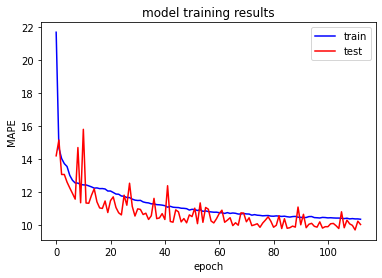

In [52]:
plot_metrics(history,"MAPE")

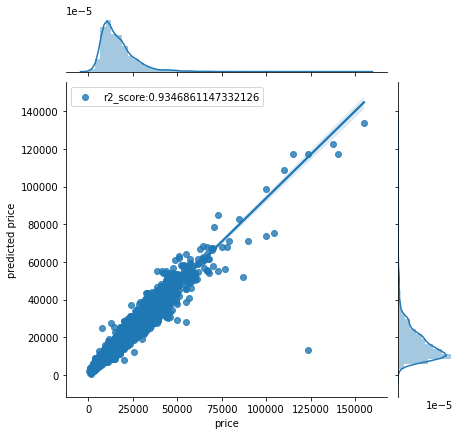

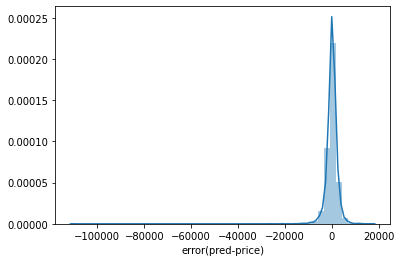

In [53]:
carPrice_embed.plot_pred_price(X_embed=test_input,y_embed=y_test)

In [54]:
price_table = carPrice_embed.price_diff(test_input,y_test)

In [55]:
price_table.head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
72016,Focus,Manual,Petrol,1,5,2,0,357.120571,357.120571
44645,Corsa,Manual,Petrol,1,3,2,0,237.921742,237.921742
29517,GLE Class,Semi-Auto,Diesel,3,4,2,1,220.384425,220.384425
70592,Fiesta,Manual,Diesel,1,4,4,0,212.905717,212.905717
27964,Octavia,Manual,Diesel,1,5,3,0,207.220428,207.220428
28029,Octavia,Manual,Diesel,1,5,3,0,143.728206,143.728206
27927,Octavia,Manual,Petrol,2,4,2,0,133.452763,133.452763
12301,Golf,Manual,Petrol,2,4,2,0,123.096791,123.096791
71883,Focus,Manual,Petrol,1,4,2,0,119.277301,119.277301
40088,C Class,Manual,Diesel,4,0,3,0,113.939347,113.939347


### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [13]:
EMBED_COLS = ["model","transmission","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [14]:
train_input_2,dev_input_2,test_input_2 = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [15]:
all_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [16]:
all_embed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [17]:
carPrice_embed.base = all_embed_model

In [19]:
carPrice_embed.regression_metrics(train_input_2,y_train,test_input_2,y_test,retrain=True,train_dataset=(train_input_2,y_train),
                                 dev_dataset=(dev_input_2,y_dev),epochs=MAX_EPOCH,V=1,callbacks=[earlystop])

Epoch 1/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 33326862.0000 - MAPE: 21.7729 - MAE: 3221.3401 - val_loss: 15505390.0000 - val_MAPE: 18.8830 - val_MAE: 2686.5647
Epoch 2/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 14828940.0000 - MAPE: 16.2943 - MAE: 2394.4824 - val_loss: 12260926.0000 - val_MAPE: 14.7565 - val_MAE: 2233.0752
Epoch 3/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 11839399.0000 - MAPE: 13.9562 - MAE: 2112.8555 - val_loss: 10556685.0000 - val_MAPE: 13.2926 - val_MAE: 2048.6152
Epoch 4/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 10567337.0000 - MAPE: 12.8731 - MAE: 1990.8756 - val_loss: 9892357.0000 - val_MAPE: 12.5974 - val_MAE: 2002.9430
Epoch 5/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 10039945.0000 - MAPE: 12.4121 - MAE: 1948.9729 - val_loss: 9559930.0000 - val_MAPE: 11.4362 - val_MAE: 1908.6647
Epoch 6/1000
2511/2511 [==================

Epoch 44/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 6361630.0000 - MAPE: 10.5828 - MAE: 1649.2706 - val_loss: 6549285.0000 - val_MAPE: 10.0054 - val_MAE: 1606.0375
Epoch 45/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 6367456.0000 - MAPE: 10.5772 - MAE: 1649.0021 - val_loss: 6605584.5000 - val_MAPE: 10.1537 - val_MAE: 1632.3964
Epoch 46/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 6344853.0000 - MAPE: 10.5404 - MAE: 1646.7415 - val_loss: 6575630.5000 - val_MAPE: 9.9193 - val_MAE: 1599.5430
Epoch 47/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 6319045.5000 - MAPE: 10.5602 - MAE: 1645.7306 - val_loss: 6758618.5000 - val_MAPE: 10.1025 - val_MAE: 1662.2524
Epoch 48/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 6310508.5000 - MAPE: 10.5363 - MAE: 1641.9419 - val_loss: 6514557.0000 - val_MAPE: 10.0324 - val_MAE: 1619.8617
Epoch 49/1000
2511/2511 [=====================

,r2_score,rmse,price_diff_abs_max
train,0.942521,2360.875202,569.961035
test,0.935012,2568.640994,322.460050


In [20]:
all_embed_model = carPrice_embed.regressor
history = carPrice_embed.history

In [21]:
all_embed_model.save("All_embed.h5")

In [22]:
# all_embed_model = tfk.models.load_model("All_embed.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

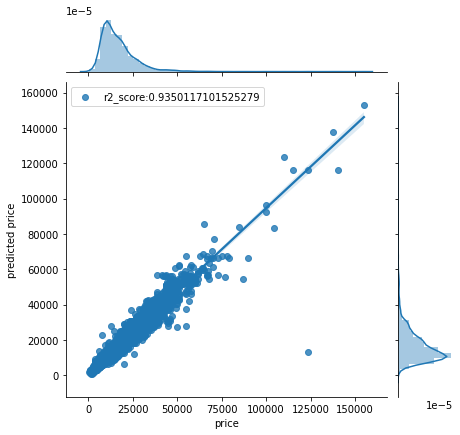

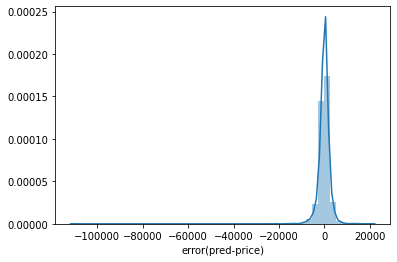

In [23]:
carPrice_embed.plot_pred_price(X_embed=test_input_2,y_embed=y_test)

In [24]:
price_table = carPrice_embed.price_diff(test_input_2,y_test)
price_table.head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
72016,Focus,Manual,Petrol,1,5,2,0,322.460050,322.460050
44645,Corsa,Manual,Petrol,1,3,2,0,199.472656,199.472656
29517,GLE Class,Semi-Auto,Diesel,3,4,2,1,192.562324,192.562324
27964,Octavia,Manual,Diesel,1,5,3,0,147.374975,147.374975
70592,Fiesta,Manual,Diesel,1,4,4,0,141.696700,141.696700
98140,A3,Manual,Petrol,2,3,2,0,134.333038,134.333038
12301,Golf,Manual,Petrol,2,4,2,0,126.431819,126.431819
40088,C Class,Manual,Diesel,4,0,3,0,115.112282,115.112282
27927,Octavia,Manual,Petrol,2,4,2,0,110.062058,110.062058
69286,Fusion,Manual,Petrol,2,3,2,0,97.648387,97.648387


### Slightly improved, still have same issues with older year. Let's import original raw data

In [12]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_raw.csv").drop("brand",axis=1)

In [13]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99186 non-null  object 
 1   year          99186 non-null  int64  
 2   price         99186 non-null  int64  
 3   transmission  99186 non-null  object 
 4   mileage       99186 non-null  int64  
 5   fuelType      99186 non-null  object 
 6   mpg           99186 non-null  float64
 7   engineSize    99186 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 6.1+ MB


In [14]:
EMBED_COLS = ["model","transmission","fuelType","year"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [15]:
carPrice_embed.features = data_raw.drop("price",axis=1)
carPrice_embed.label=data_raw.price
X_train_r,X_test_r,y_train_r,y_test_r = carPrice_embed.data_split(1988,0.1)
X_train_r,X_dev_r,y_train_r,y_dev_r = train_test_split(X_train_r,y_train_r,test_size=0.1,random_state=1988)

In [16]:
train_input_r,dev_input_r,test_input_r = cate_embed_process(X_train_r,X_dev_r,X_test_r,EMBED_COLS)

In [17]:
embed_model_r = embed_model_setup(EMBED_COLS,X_train_r,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [18]:
embed_model_r.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [21]:
carPrice_embed.base = embed_model_r

In [22]:
carPrice_embed.regression_metrics(train_input_r,y_train_r,test_input_r,y_test_r,retrain=True,
                                  train_dataset=(train_input_r,y_train_r),
                                 dev_dataset=(dev_input_r,y_dev_r),
                                  epochs=MAX_EPOCH,V=1,callbacks=[earlystop])

Epoch 1/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 137223520.0000 - MAPE: 49.0634 - MAE: 7542.8057 - val_loss: 34965796.0000 - val_MAPE: 20.4469 - val_MAE: 3455.9087
Epoch 2/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 26510174.0000 - MAPE: 19.7461 - MAE: 3006.7500 - val_loss: 15543099.0000 - val_MAPE: 14.0468 - val_MAE: 2284.3037
Epoch 3/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 18030944.0000 - MAPE: 16.1743 - MAE: 2499.2278 - val_loss: 13481314.0000 - val_MAPE: 13.5985 - val_MAE: 2187.1714
Epoch 4/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 15125353.0000 - MAPE: 15.0098 - MAE: 2325.1440 - val_loss: 10848898.0000 - val_MAPE: 13.2605 - val_MAE: 2057.9661
Epoch 5/1000
2511/2511 [==============================] - 7s 3ms/step - loss: 15106611.0000 - MAPE: 15.3442 - MAE: 2352.9165 - val_loss: 10525974.0000 - val_MAPE: 12.0597 - val_MAE: 1998.5450
Epoch 6/1000
2511/2511 [===============

,r2_score,rmse,price_diff_abs_max
train,0.916846,2839.598526,598.823539
test,0.903817,3124.898415,634.709399


In [23]:
embed_model_r = carPrice_embed.regressor
history = carPrice_embed.history

In [24]:
embed_model_r.save("model_embed_raw.h5")

In [25]:
# embed_model_r = tfk.models.load_model("model_embed_raw.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

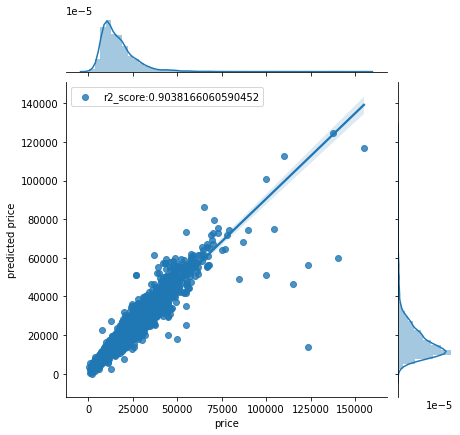

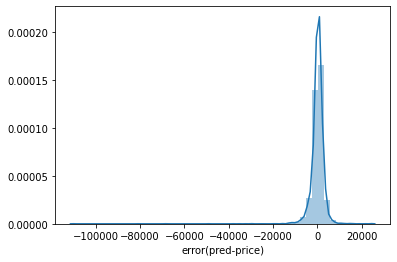

In [27]:
carPrice_embed.plot_pred_price(X_embed=test_input_r,y_embed=y_test_r)

In [28]:
price_table = carPrice_embed.price_diff(test_input_r,y_test_r)
price_table.head(20)

,model,year,transmission,mileage,fuelType,mpg,engineSize,price_diff_pct,price_diff_abs
72016,Focus,2003,Manual,177644,Petrol,41.5,1.6,634.709399,634.709399
27964,Octavia,2010,Manual,300000,Diesel,57.6,1.9,372.747136,372.747136
29517,GLE Class,2016,Semi-Auto,77456,Diesel,42.8,3.0,192.371699,192.371699
71860,Focus,2009,Manual,139600,Petrol,48.7,1.6,137.477084,137.477084
28029,Octavia,2008,Manual,110265,Diesel,54.3,1.9,136.824528,136.824528
12006,Golf,2009,Manual,193000,Diesel,52.3,2.0,132.451519,132.451519
12232,Golf,2010,Manual,122437,Diesel,57.6,2.0,111.484180,111.484180
39408,E Class,2009,Automatic,131711,Diesel,27.7,3.0,111.228269,111.228269
40088,C Class,2019,Manual,3000,Diesel,50.4,1.5,110.265216,110.265216
70592,Fiesta,2006,Manual,97556,Diesel,62.8,1.4,109.655207,109.655207


### Let's use numeric binned data instead

In [29]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)

In [30]:
carPrice_embed.features = combined.drop("price",axis=1)
carPrice_embed.label=combined.price
X_train_c,X_test_c,y_train_c,y_test_c = carPrice_embed.data_split(1988,0.1)
X_train_c,X_dev_c,y_train_c,y_dev_c = train_test_split(X_train_c,y_train_c,test_size=0.1,random_state=1988)

In [31]:
EMBED_COLS = ["model","transmission","fuelType","year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [32]:
train_input_c,dev_input_c,test_input_c = cate_embed_process(X_train_c,X_dev_c,X_test_c,EMBED_COLS)

In [33]:
embed_model_c = embed_model_setup(EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [34]:
embed_model_c.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [35]:
carPrice_embed.base = embed_model_c

In [36]:
carPrice_embed.regression_metrics(train_input_c,y_train_c,test_input_c,y_test_c,retrain=True,
                                  train_dataset=(train_input_c,y_train_c),
                                 dev_dataset=(dev_input_c,y_dev_c),
                                  epochs=MAX_EPOCH,V=1,callbacks=[earlystop])

Epoch 1/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 31738548.0000 - MAPE: 20.8353 - MAE: 3102.7319 - val_loss: 13582133.0000 - val_MAPE: 15.9115 - val_MAE: 2359.1890
Epoch 2/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 13295523.0000 - MAPE: 14.9924 - MAE: 2210.7554 - val_loss: 10751712.0000 - val_MAPE: 13.2508 - val_MAE: 2040.1172
Epoch 3/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 10482466.0000 - MAPE: 12.6163 - MAE: 1934.7758 - val_loss: 9483090.0000 - val_MAPE: 11.5338 - val_MAE: 1847.2802
Epoch 4/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 9497847.0000 - MAPE: 11.6880 - MAE: 1841.1296 - val_loss: 8723772.0000 - val_MAPE: 11.3757 - val_MAE: 1834.4185
Epoch 5/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 9050832.0000 - MAPE: 11.2063 - MAE: 1803.4481 - val_loss: 8369405.0000 - val_MAPE: 10.6203 - val_MAE: 1774.8370
Epoch 6/1000
2511/2511 [=====================

2511/2511 [==============================] - 8s 3ms/step - loss: 5309574.5000 - MAPE: 9.2812 - MAE: 1491.0764 - val_loss: 5839206.5000 - val_MAPE: 8.7324 - val_MAE: 1443.3995
Epoch 45/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 5323046.0000 - MAPE: 9.3048 - MAE: 1492.1185 - val_loss: 5904646.5000 - val_MAPE: 8.8398 - val_MAE: 1457.4207
Epoch 46/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 5321684.5000 - MAPE: 9.2788 - MAE: 1490.5939 - val_loss: 5944246.0000 - val_MAPE: 8.9101 - val_MAE: 1457.6233
Epoch 47/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 5282087.0000 - MAPE: 9.2886 - MAE: 1492.0829 - val_loss: 6014042.5000 - val_MAPE: 8.7124 - val_MAE: 1448.5991
Epoch 48/1000
2511/2511 [==============================] - 8s 3ms/step - loss: 5259042.5000 - MAPE: 9.2325 - MAE: 1483.3810 - val_loss: 5993256.0000 - val_MAPE: 9.5427 - val_MAE: 1511.6183
Epoch 49/1000
2511/2511 [==============================] - 8s 3ms/ste

,r2_score,rmse,price_diff_abs_max
train,0.951692,2164.336517,493.584533
test,0.941509,2436.859103,206.995968


In [37]:
embed_model_c = carPrice_embed.regressor

In [38]:
embed_model_c.save("combined_embed_all.h5")

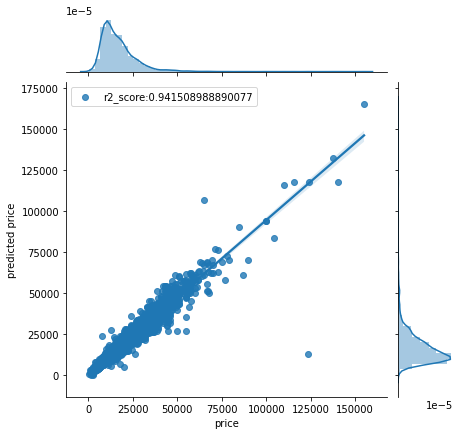

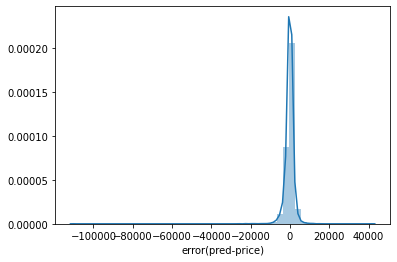

In [39]:
carPrice_embed.plot_pred_price(X_embed=test_input_c,y_embed=y_test_c)

In [40]:
price_table = carPrice_embed.price_diff(test_input_c,y_test_c)
price_table.head(20)

,model,transmission,fuelType,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
29517,GLE Class,Semi-Auto,Diesel,4,2,1,2016,206.995968,206.995968
27964,Octavia,Manual,Diesel,5,3,0,2010,196.644010,196.644010
72016,Focus,Manual,Petrol,5,2,0,2003,118.716881,118.716881
54909,Vectra,Manual,Petrol,4,1,0,2007,117.222061,117.222061
40088,C Class,Manual,Diesel,0,3,0,2019,115.427174,115.427174
16081,Polo,Manual,Petrol,4,2,0,2009,108.710103,108.710103
6304,Prius,Automatic,Hybrid,5,4,0,2008,99.834314,99.834314
16734,Polo,Manual,Petrol,3,2,0,2009,96.665930,96.665930
81375,2 Series,Semi-Auto,Diesel,3,4,0,2015,-89.542767,89.542767
54910,Vectra,Manual,Petrol,4,1,0,2005,86.707270,86.707270


### The binned numeric value did better than original numerica data. 

--- 

### Let's focus on binned numeric value with original year embed model and adjust learning rate first 

2511/2511 [==============================] - 9s 3ms/step - loss: nan - MAPE: nan - MAE: nan - val_loss: nan - val_MAPE: nan - val_MAE: nan


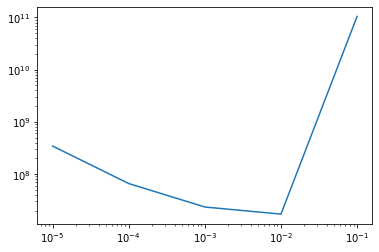

In [45]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5,1e6]
mdl_setup = partial(embed_model_setup, EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,embed_size_multiplier=4.0)
param_search(learning_rates,mdl_setup,train_input_c,y_train_c,dev_input_c,y_dev_c,xlog=True,ylog=True)

2511/2511 [==============================] - 9s 3ms/step - loss: 17629738.0000 - MAPE: 16.2525 - MAE: 2509.0679 - val_loss: 9833226.0000 - val_MAPE: 11.1189 - val_MAE: 1856.4135


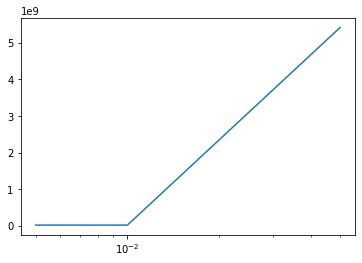

In [46]:
learning_rates = [5e-2,1e-2,5e-3]
param_search(learning_rates,mdl_setup,train_input_c,y_train_c,dev_input_c,y_dev_c,xlog=True,ylog=False)

### learning rate of 0.001 seems to work the best

In [48]:
mdl_partial = partial(embed_model_setup, EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,0.001)

2511/2511 [==============================] - 9s 3ms/step - loss: 24318146.0000 - MAPE: 18.4544 - MAE: 2741.9492 - val_loss: 10493599.0000 - val_MAPE: 13.1388 - val_MAE: 2027.9554


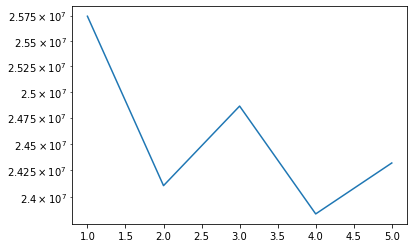

In [49]:
multipler = [1,2,3,4,5]
param_search(multipler,mdl_partial,train_input_c,y_train_c,dev_input_c,y_dev,xlog=False,ylog=True)

In [50]:
final_mdl = mdl_partial(3)

In [51]:
final_mdl.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_122 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_123 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_124 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_125 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [52]:
carPrice_embed.base = final_mdl
carPrice_embed.regression_metrics(train_input_c,y_train_c,test_input_c,y_test_c,retrain=True,
                                  train_dataset=(train_input_c,y_train_c),
                                 dev_dataset=(dev_input_c,y_dev_c),
                                  epochs=MAX_EPOCH,V=1,callbacks=[earlystop])

Epoch 1/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 24794132.0000 - MAPE: 19.0003 - MAE: 2808.5657 - val_loss: 11135710.0000 - val_MAPE: 13.6321 - val_MAE: 2090.6362
Epoch 2/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 10864914.0000 - MAPE: 12.8236 - MAE: 1973.9607 - val_loss: 9644019.0000 - val_MAPE: 12.0024 - val_MAE: 1958.3044
Epoch 3/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 9640486.0000 - MAPE: 11.7524 - MAE: 1872.5674 - val_loss: 8613609.0000 - val_MAPE: 11.0465 - val_MAE: 1810.0590
Epoch 4/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 8928375.0000 - MAPE: 11.3375 - MAE: 1818.6547 - val_loss: 7904881.0000 - val_MAPE: 10.1670 - val_MAE: 1705.9442
Epoch 5/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 8072559.5000 - MAPE: 11.0409 - MAE: 1767.2308 - val_loss: 7471249.5000 - val_MAPE: 10.4372 - val_MAE: 1711.3792
Epoch 6/1000
2511/2511 [=======================

2511/2511 [==============================] - 9s 3ms/step - loss: 5121097.0000 - MAPE: 9.1283 - MAE: 1463.3846 - val_loss: 5824510.5000 - val_MAPE: 8.7152 - val_MAE: 1424.3391
Epoch 45/1000
2511/2511 [==============================] - 9s 3ms/step - loss: 5053531.0000 - MAPE: 9.0744 - MAE: 1456.3936 - val_loss: 5830423.0000 - val_MAPE: 8.6050 - val_MAE: 1434.4613
Epoch 00045: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.952369,2149.131508,374.771346
test,0.941193,2443.434206,203.934425


In [55]:
final_mdl = carPrice_embed.regressor

In [56]:
final_mdl.save("final_embed_mdl.h5")

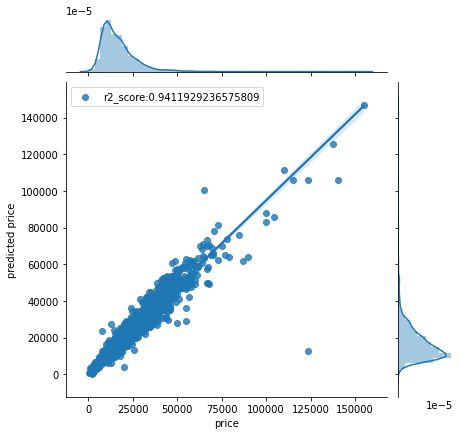

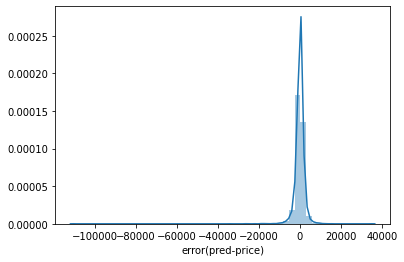

In [57]:
carPrice_embed.plot_pred_price(X_embed=test_input_c,y_embed=y_test_c)

In [58]:
price_table = carPrice_embed.price_diff(test_input_c,y_test_c)
price_table.head(20)

,model,transmission,fuelType,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
29517,GLE Class,Semi-Auto,Diesel,4,2,1,2016,203.934425,203.934425
27964,Octavia,Manual,Diesel,5,3,0,2010,192.919635,192.919635
40088,C Class,Manual,Diesel,0,3,0,2019,113.524997,113.524997
54910,Vectra,Manual,Petrol,4,1,0,2005,96.725739,96.725739
71900,Fusion,Manual,Petrol,5,2,0,2008,-92.531584,92.531584
72016,Focus,Manual,Petrol,5,2,0,2003,91.145895,91.145895
54909,Vectra,Manual,Petrol,4,1,0,2007,90.407640,90.407640
81375,2 Series,Semi-Auto,Diesel,3,4,0,2015,-89.572759,89.572759
40020,M Class,Automatic,Diesel,5,1,1,2004,-80.681187,80.681187
77366,I20,Manual,Petrol,4,3,0,2010,77.400471,77.400471


### Conclusions

### More tuning on dropout and other params can enhance the models but embed gives the best results